In [1]:
import os

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader, random_split

# Criação do Dataset

In [2]:
def get_data(path):
    paths = []
    tiles = os.listdir(path)
    for tile in range(1, len(tiles)):
        images = os.listdir(f"{path}/{tile}/images")
        for image in images:
            paths.append({"image": f"{path}/{tile}/images/{image}", "label": f"{path}/{tile}/masks/{image}".replace("jpg", "png")})
    return paths

In [3]:
class ProcessedImagesDataset(Dataset):
    def __init__(self, img_dir):
        self.data = get_data(img_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]["image"]
        mask_path = self.data[idx]["label"]
        image, mask = read_image(image_path, ImageReadMode.RGB), (read_image(mask_path, ImageReadMode.GRAY))
        label = np.zeros_like(mask)
        label[mask >= 250] = 1
        return image, label

# Treino

In [4]:
import matplotlib.pyplot as plt

In [5]:
dataset = ProcessedImagesDataset("data/processed")
train_data, test_data = random_split(dataset, [50, 22])
dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
from scripts.unet import UNet
import torch.optim as optim

In [8]:
def train_fn(loader: DataLoader, model: torch.nn.Module, optimizer: optim.Optimizer, loss_fn, scaler, epochs):
    for epoch in range(epochs):
        model.train()

        batch_loss = 0

        for batch_idx, (data, target) in enumerate(loader):
            data = data.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)

            assert data.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {data.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

            # forward
            predicted = model(data)
            loss = loss_fn(predicted, target)
            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            batch_loss += loss.item()
        print (f'Epoch [{epoch+1}/{epochs}], Loss: {batch_loss:.4f}')

# Main

In [9]:
def main():
    images_path = "data/processed"

    torch.cuda.empty_cache()
    model = UNet(3, 1).to(device=device)
    dataset = ProcessedImagesDataset(images_path)
    train_data, test_data = random_split(dataset, [50, 22])
    dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
    loss_fn = nn.BCEWithLogitsLoss()
    grad_scaler = torch.cuda.amp.GradScaler()
    epochs = 10
    try:
        train_fn(dataloader, model, optimizer, loss_fn, grad_scaler, epochs)
    except KeyboardInterrupt:
        torch.save(model.state_dict(), 'INTERRUPTED.pth')
    torch.save(model.state_dict(), 'model.pth')
    return model
predictor = main()

Epoch [1/10], Loss: 17.6685
Epoch [2/10], Loss: 15.0219
Epoch [3/10], Loss: 14.6111
Epoch [4/10], Loss: 14.8503
Epoch [5/10], Loss: 14.3545
Epoch [6/10], Loss: 14.7448
Epoch [7/10], Loss: 14.3038
Epoch [8/10], Loss: 13.9132
Epoch [9/10], Loss: 14.3528
Epoch [10/10], Loss: 15.2710


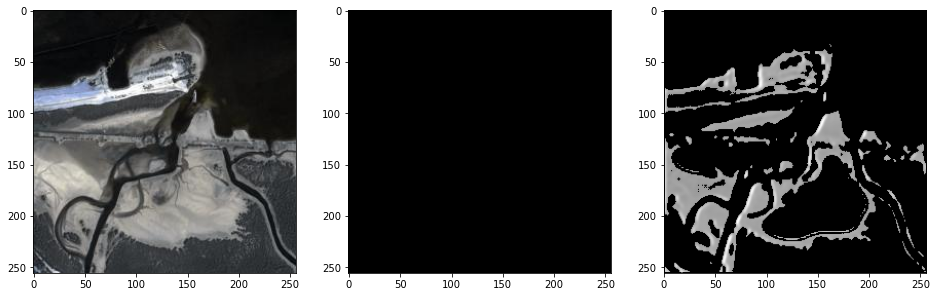

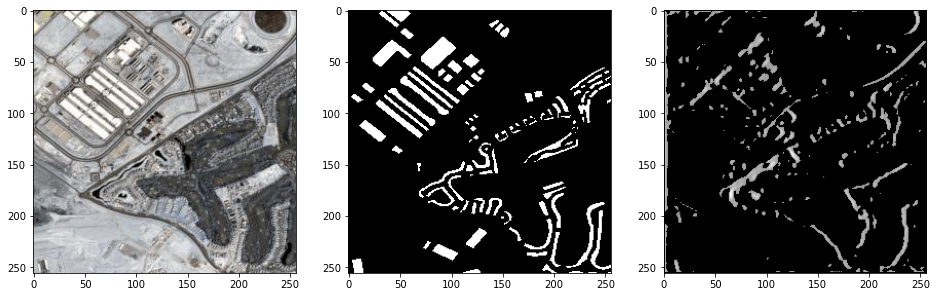

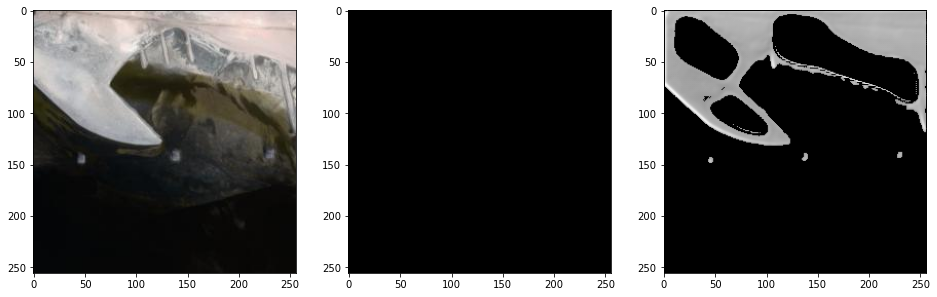

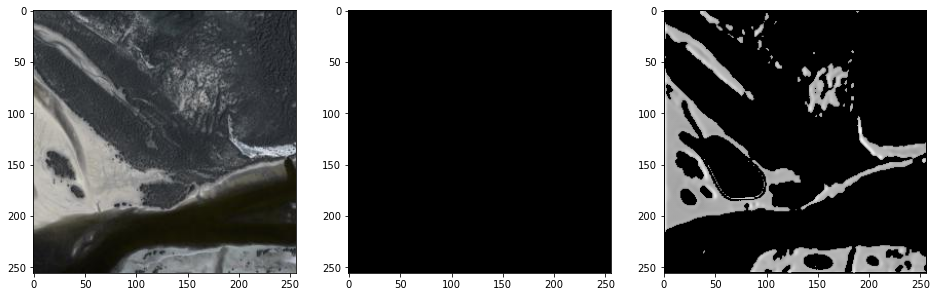

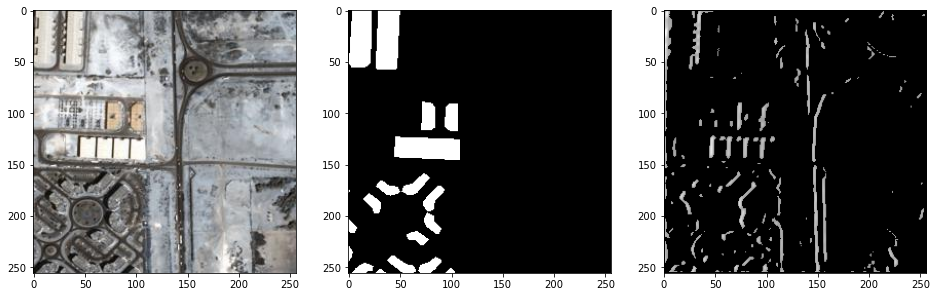

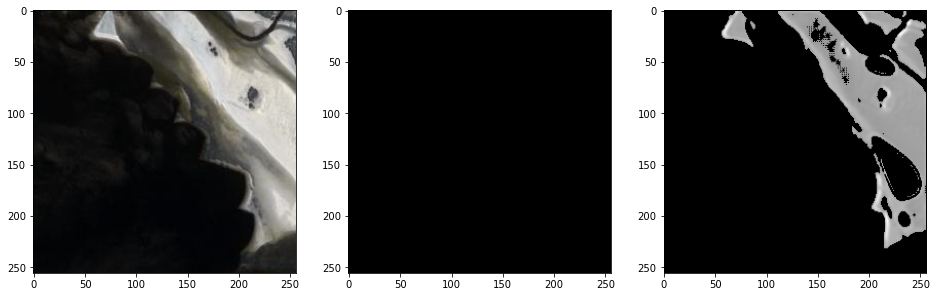

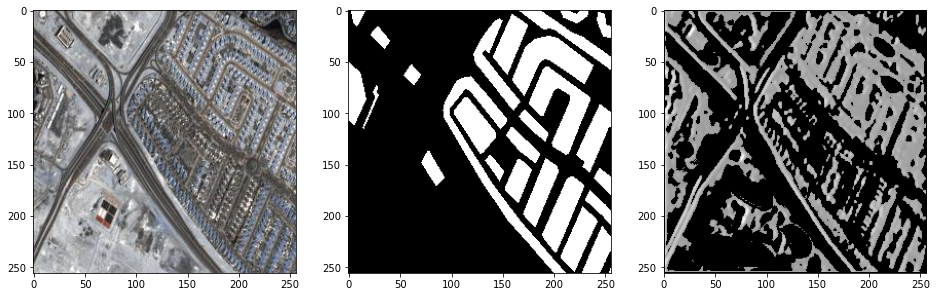

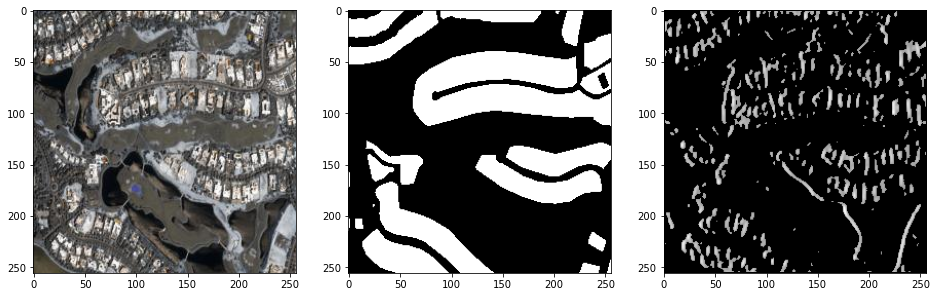

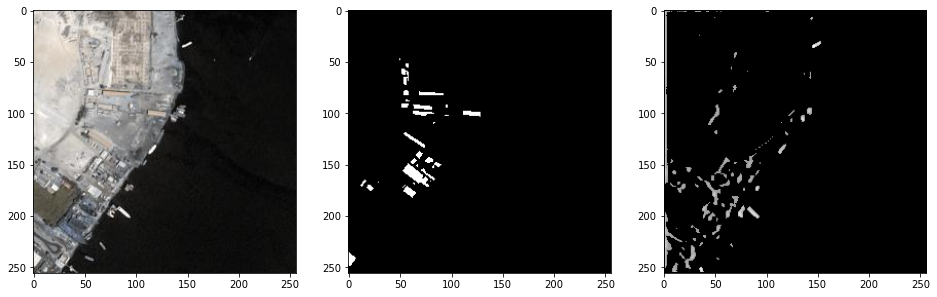

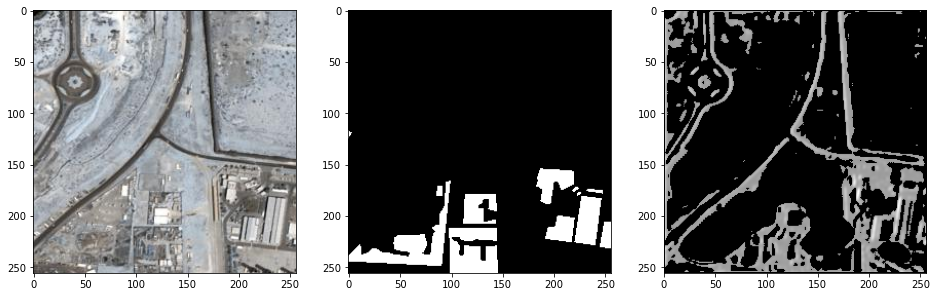

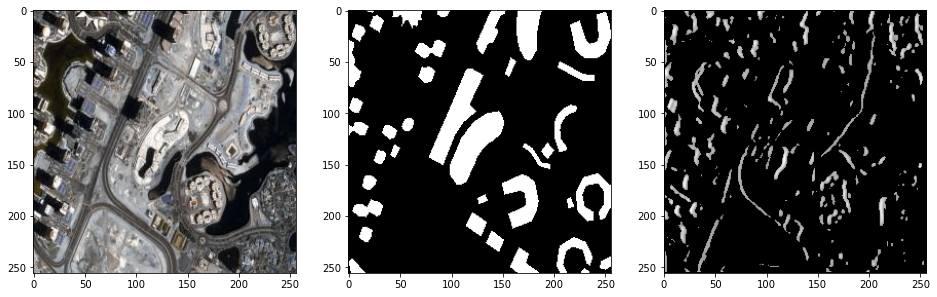

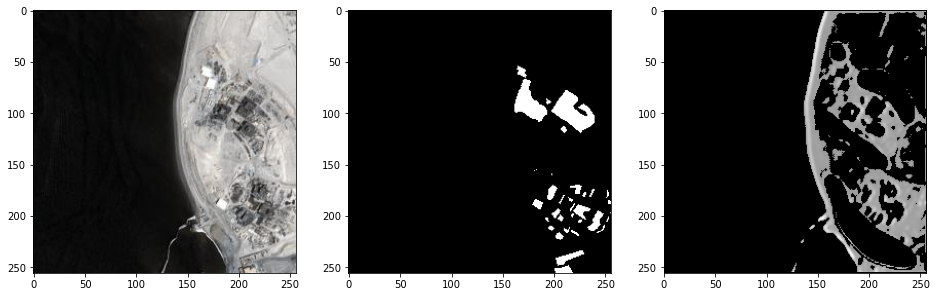

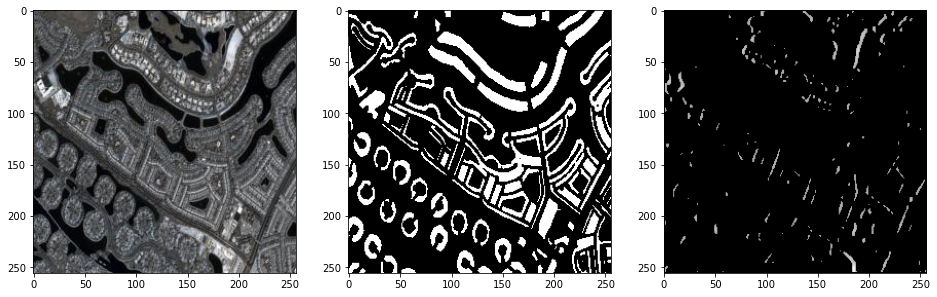

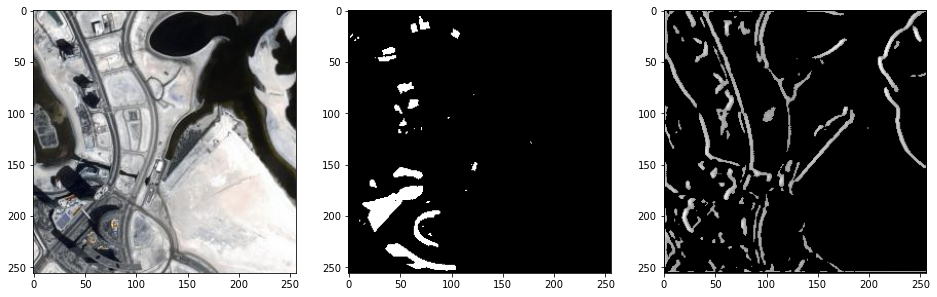

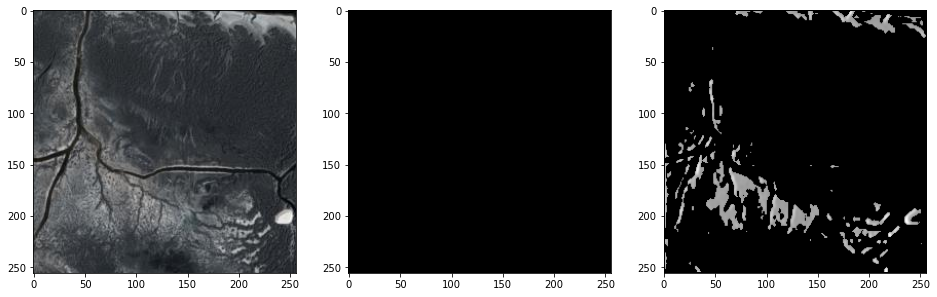

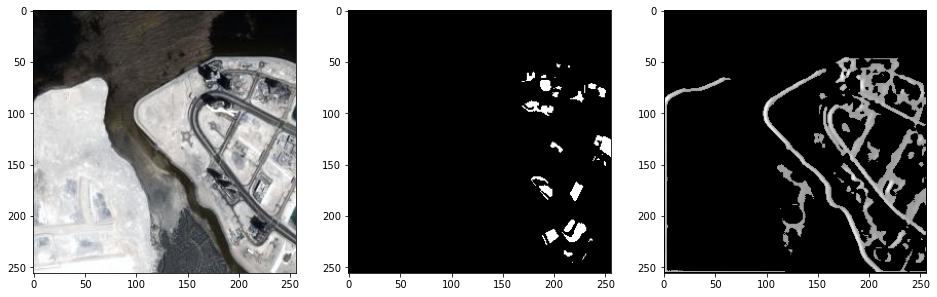

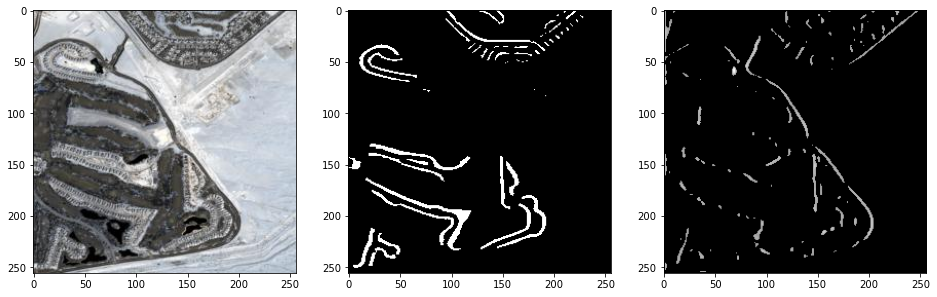

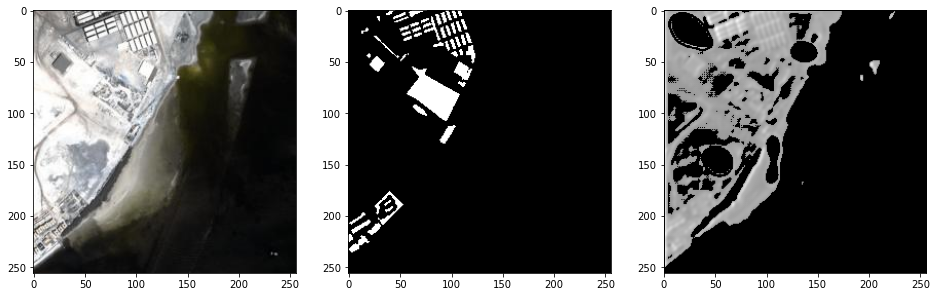

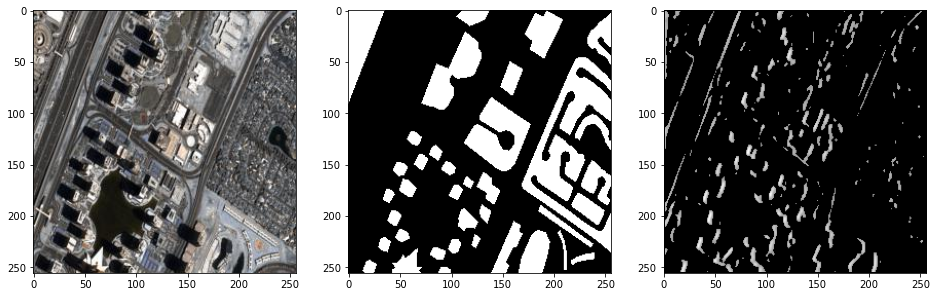

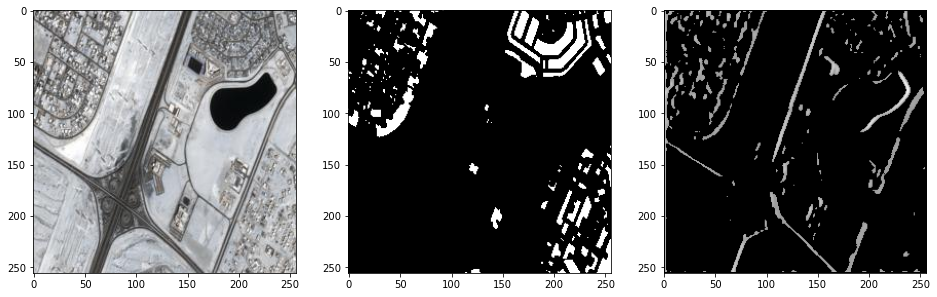

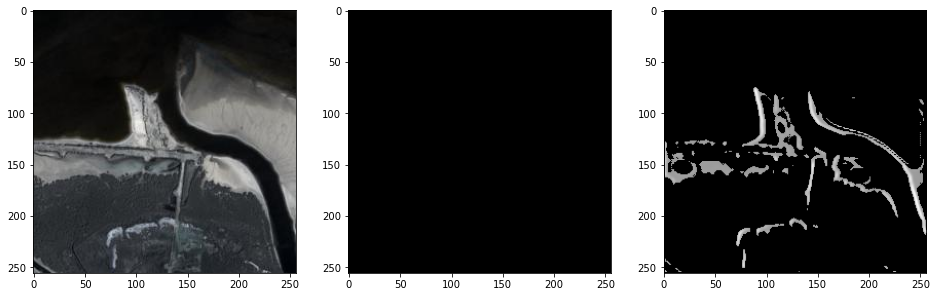

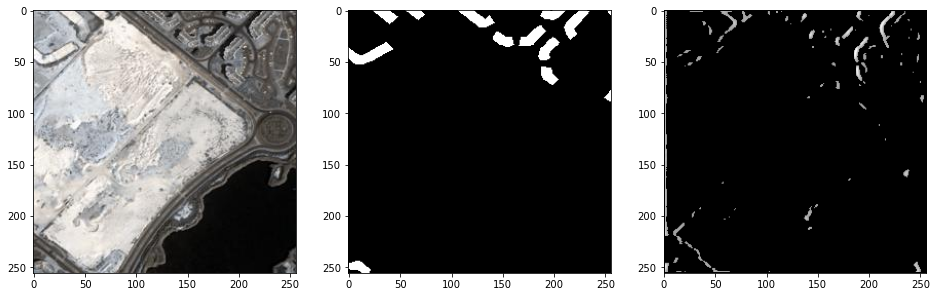

In [50]:
with torch.no_grad():
    images_path = "data/processed"
    dataset = ProcessedImagesDataset(images_path)
    train_data, test_data = random_split(dataset, [50, 22])
    dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

    if not predictor:
        predictor = UNet(3, 1).cuda()
        predictor.load_state_dict(torch.load("model.pth"))

    predictor.eval()

    for batch in dataloader:
        image, label = batch
        predicted = nn.functional.sigmoid(predictor(image.to(device, torch.float32)))

        plt.figure(figsize=(16, 16))
        plt.subplot(131)
        plt.imshow(np.transpose(image[0], axes=[1, 2, 0]), cmap="gray")
        plt.subplot(132)
        plt.imshow(np.transpose(label[0], axes=[1, 2, 0]), cmap="gray")
        plt.subplot(133)

        predicted = np.transpose(predicted[0].cpu(), axes=[1, 2, 0])
        mask = np.copy(predicted)
        mask.reshape((mask.shape[0], mask.shape[1]))
        mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
        mask[mask < 0.6] = 0
        plt.imshow(mask, cmap="gray")
        plt.show()

In [11]:
images_path = "data/processed"
dataset = ProcessedImagesDataset(images_path)
train_data, test_data = random_split(dataset, [50, 22])

test_data[0][1].shape

(1, 256, 256)